# **Using aeon Distances with scikit-learn Clusterers**

This notebook demonstrates how to integrate aeon’s distance metrics with hierarchical, density-based, and spectral clustering methods from scikit-learn. While aeon primarily supports partition-based clustering algorithms, such as $k$-means and $k$-medoids, its robust distance measures can be leveraged to enable other clustering techniques using scikit-learn.

To measure similarity between time series and enable clustering, we use aeon’s precomputed distance matrices. For details about distance metrics, see the [distance examples](../distances/distances.ipynb).

## **Contents**
1. **Example Dataset**: Using the `load_unit_test` dataset from aeon.
2. **Computing Distance Matrices with aeon**: Precomputing distance matrices with aeon’s distance metrics.
3. **Hierarchical Clustering**
4. **Density-Based Clustering**
5. **Spectral Clustering**

## **Example Dataset**

We'll begin by loading a sample dataset. For this demonstration, we'll use the `load_unit_test` dataset from aeon.


In [ ]:
# Import & load data
from aeon.datasets import load_unit_test

X, y = load_unit_test(split="train")

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Data shape: (20, 1, 24)
Labels shape: (20,)


## **Computing Distance Matrices with aeon**

Aeon provides a variety of distance measures suitable for time series data. We'll compute the distance matrix using the Dynamic Time Warping (DTW) distance as an example.

For a comprehensive overview of all available distance metrics in aeon, see the [aeon distances API reference](../api_reference/distances.html).


In [ ]:
from aeon.distances import pairwise_distance

# Compute the pairwise distance matrix using DTW
distance_matrix = pairwise_distance(X, method="dtw")

print(f"Distance matrix shape: {distance_matrix.shape}")

Distance matrix shape: (20, 20)


## **Hierarchical Clustering**

[AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) is, as the name suggests, an agglomerative approach that works by merging clusters bottom-up. 
 

Hierarchical clustering builds a hierarchy of clusters either by progressively merging or splitting existing clusters. We'll use scikit-learn's AgglomerativeClustering with the precomputed distance matrix.

Not all linkage methods can be used with a precomputed distance matrix. The following linkage methods work with aeon distances:
- `single`
- `complete`
- `average`
- `weighted`

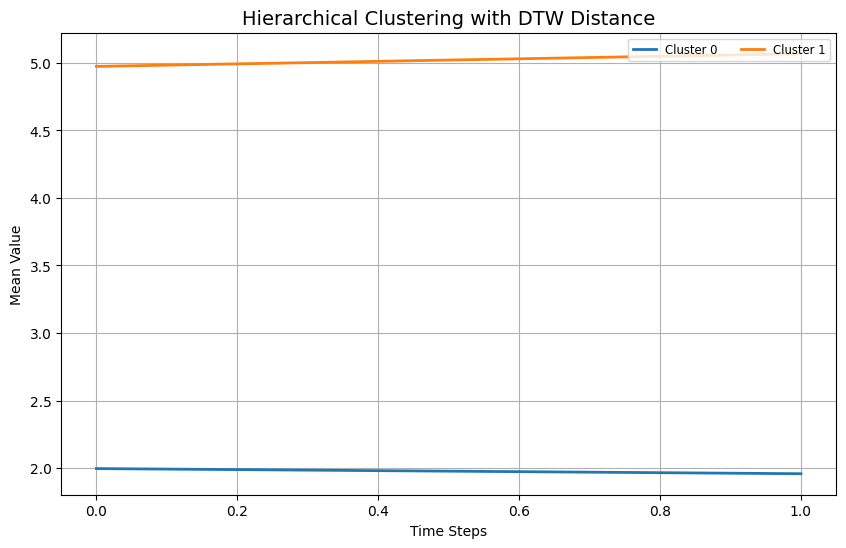

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, metric="precomputed", linkage="average")
labels = agg_clustering.fit_predict(distance_matrix)

# Visualize the clustering results
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    cluster_data = X[labels == label]  # Ensure correct slicing
    plt.plot(np.mean(cluster_data, axis=0), label=f"Cluster {label}", linewidth=2)

plt.title("Hierarchical Clustering with DTW Distance", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Mean Value")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True)
plt.show()

## **Density-Based Clustering**
Density-based clustering identifies clusters based on the density of data points in the feature space. We'll demonstrate this using scikit-learn's `DBSCAN` and `OPTICS` algorithms.

### **DBSCAN**

[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) is a density-based clustering algorithm that groups data points based on their density connectivity. 
We use the `DBSCAN` algorithm from scikit-learn with a precomputed distance matrix.


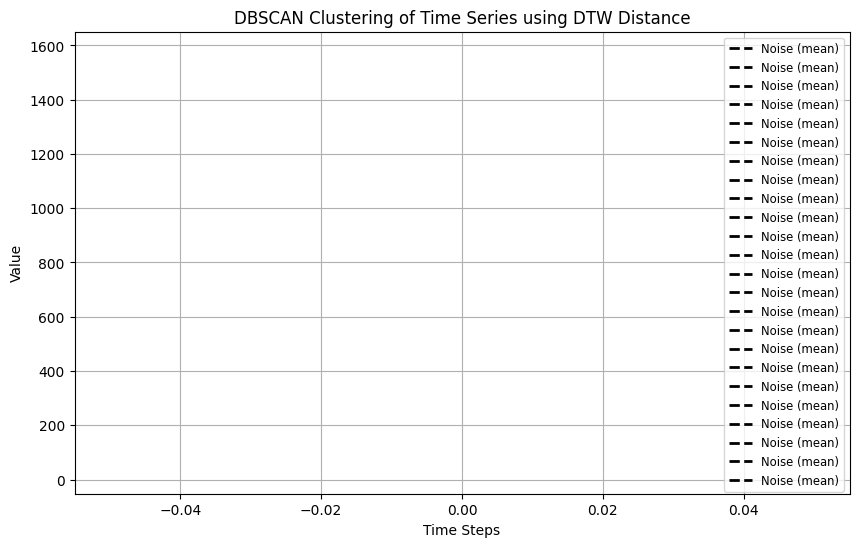

In [8]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric="precomputed")
dbscan_labels = dbscan.fit_predict(distance_matrix)

# Visualize the clustering results
plt.figure(figsize=(10, 6))

unique_labels = np.unique(dbscan_labels)

for label in unique_labels:
    cluster_data = X[np.where(dbscan_labels == label)]
    
    if label == -1:
        for ts in cluster_data[:3]:  # show up to 3 noise series
            plt.plot(ts, color='gray', alpha=0.4)
        plt.plot(cluster_data.mean(axis=0), color='black', linestyle='--', linewidth=2, label="Noise (mean)")
    else:
        for ts in cluster_data[:3]:  # show up to 3 series from each cluster
            plt.plot(ts, alpha=0.3)
        plt.plot(cluster_data.mean(axis=0), linewidth=3, label=f"Cluster {label} (mean)")

plt.title("DBSCAN Clustering of Time Series using DTW Distance")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend(fontsize="small")
plt.grid(True)
plt.show()


### **OPTICS**
[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) is a density-based clustering algorithm similar to DBSCAN but provides better handling of varying 
densities. We use the `OPTICS` algorithm from scikit-learn with a precomputed distance matrix.

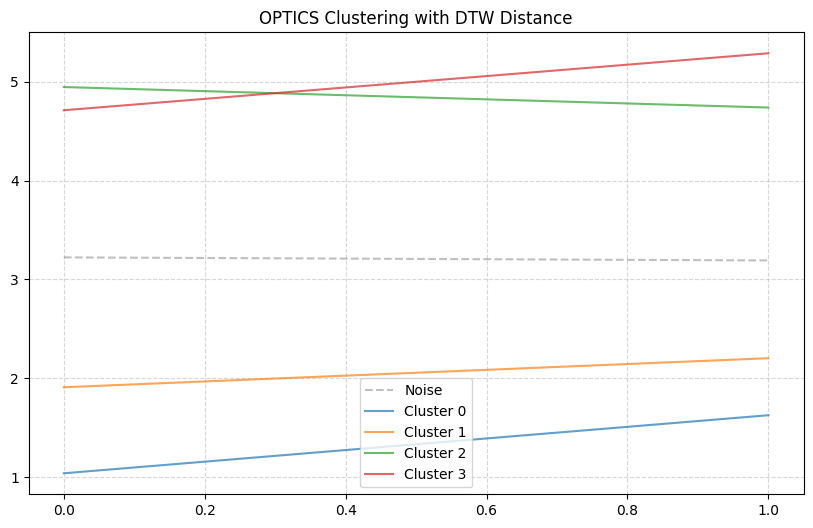

In [137]:
from sklearn.cluster import OPTICS

# Perform OPTICS clustering
optics = OPTICS(min_samples=5, metric="precomputed")
optics_labels = optics.fit_predict(distance_matrix)

# Visualize the clustering results
plt.figure(figsize=(10, 6))
colors = plt.colormaps["tab10"]

for label in np.unique(optics_labels):
    cluster_data = X[optics_labels == label]

    if cluster_data.size == 0:
        continue  # Skip empty clusters

    # Ensure correct shape for plotting
    cluster_data = np.squeeze(cluster_data)
    if cluster_data.ndim == 1:  
        cluster_data = cluster_data[:, np.newaxis]  # Convert to 2D if needed

    # Compute mean representation of each cluster
    cluster_mean = cluster_data.mean(axis=0)  

    # Plot noise separately
    if label == -1:
        plt.plot(cluster_mean, linestyle="--", color="gray", alpha=0.5, label="Noise")
    else:
        plt.plot(cluster_mean, color=colors(label % colors.N), alpha=0.7, label=f"Cluster {label}")

plt.title("OPTICS Clustering with DTW Distance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Light grid for better readability
plt.show()


## **Spectral Clustering**
[SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) performs dimensionality reduction on the data before clustering in fewer dimensions. It requires a similarity matrix, so we'll convert our distance matrix accordingly.

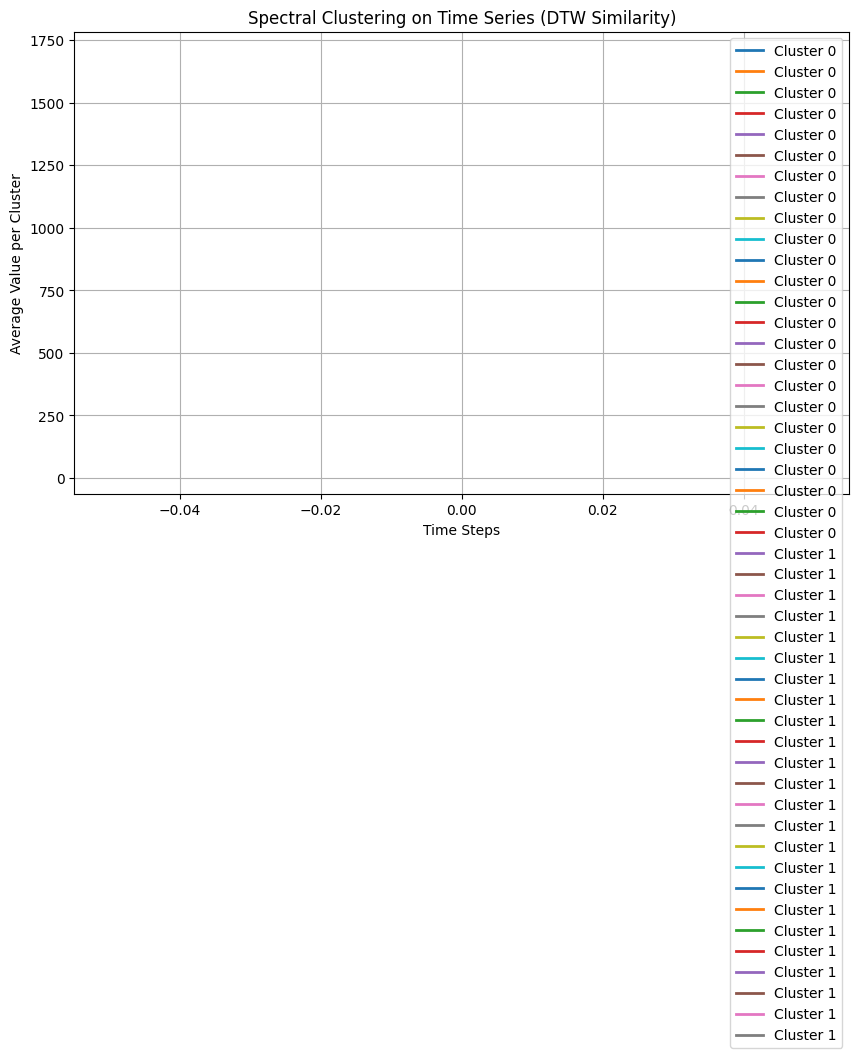

Each line represents the mean time series of a cluster identified via Spectral Clustering. This shows how time series with similar temporal patterns are grouped together using DTW-based similarity.


In [7]:

from aeon.datasets import load_unit_test
from aeon.distances import pairwise_distance
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np

# Load time series data
X, y = load_unit_test(split="train")

# Compute DTW distance matrix for time series
distance_matrix = pairwise_distance(X, method="dtw")

# Convert distance matrix to similarity (SpectralClustering requires similarity)
similarity_matrix = 1 - (distance_matrix / np.max(distance_matrix))

# Apply Spectral Clustering using precomputed similarity
spectral = SpectralClustering(n_clusters=2, affinity="precomputed", random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Visualize results: plot average time series per cluster
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    cluster_data = X[labels == label]
    cluster_mean = np.mean(cluster_data, axis=0)
    plt.plot(cluster_mean, linewidth=2, label=f"Cluster {label}")

plt.title("Spectral Clustering on Time Series (DTW Similarity)")
plt.xlabel("Time Steps")
plt.ylabel("Average Value per Cluster")
plt.legend()
plt.grid(True)
plt.show()

# Optional: this is short description output to clarify relevance
print(
    "Each line represents the mean time series of a cluster identified via Spectral Clustering. "
    "This shows how time series with similar temporal patterns are grouped together using DTW-based similarity."
)
